### Import libraries and data

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/unique_outages2.csv', parse_dates=['Start', 'Finish', 'file_name'])
df['Duration_Category'].value_counts()

Duration_Category
11.0–14.0 hrs    649
20.8+ hrs        558
9.5–11.0 hrs     525
2.8–9.5 hrs      395
0–2.8 hrs        114
14.0–20.8 hrs     30
Name: count, dtype: int64

### Function for model training 

In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

def train_lr_model(df, params=None, fine_tune=False, test_size=0.2, random_state=42):
    # Suppress ConvergenceWarning
    warnings.simplefilter("ignore", ConvergenceWarning)
    
    # --- 1. Select Features and Target
    features = ['Recall_Day_Hours', 'Recall_Night_Hours', # numerical columns
                'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional', # boolean columns
                'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description' # categorical columns
                ] 
    target = 'Duration_Category'

    X = df[features].copy()
    y = df[target]

    # --- 2. Encode Categorical Features
    for col in ['Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']:
        X[col] = LabelEncoder().fit_transform(X[col])

    # --- 3. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # --- 4. Train Model (if needed)
    model = LogisticRegression(random_state=random_state, max_iter=10000, solver='liblinear')

    if params is not None:
        # If params are passed, use those for the model
        print(f"Using provided parameters: {params}")
        model = LogisticRegression(random_state=random_state, **params)
        model.fit(X_train, y_train)
    elif fine_tune:
        # --- Fine-tuning with GridSearchCV (only if fine_tune=True and params are not provided)
        print("Performing GridSearchCV to find the best parameters...")
        param_grid = {
            'C': [0.01, 0.1, 1, 10],  # Regularization strength
            'solver': ['liblinear', 'saga'],  # Solvers to try
            'max_iter': [100, 200, 300],  # Max iterations for convergence
            'penalty': ['l2']  # L2 penalty is commonly used
        }

        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                   cv=5, n_jobs=-1, verbose=0, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        # Get the best model from grid search
        model = grid_search.best_estimator_
        print("Best Hyperparameters from GridSearchCV:", grid_search.best_params_)

    else:
        # If no params and no fine_tuning, just train with default LogisticRegression parameters
        print("Training with default LogisticRegression parameters...")
        model.fit(X_train, y_train)

    return model, X_train, X_test, y_train, y_test

### Import function for model evaluation

In [4]:
from data.functions.eval_model import evaluate_lr_model

In [5]:
# train model on all data, and fine tune it to find best params
model, X_train, X_test, y_train, y_test = train_lr_model(df, fine_tune=True)

Performing GridSearchCV to find the best parameters...


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

Best Hyperparameters from GridSearchCV: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.00      0.00      0.00        21
  2.8–9.5 hrs       0.67      0.52      0.59        83
 9.5–11.0 hrs       0.43      0.63      0.51       106
11.0–14.0 hrs       0.64      0.48      0.55       126
14.0–20.8 hrs       0.00      0.00      0.00         5
    20.8+ hrs       0.65      0.80      0.72       114

     accuracy                           0.58       455
    macro avg       0.40      0.41      0.39       455
 weighted avg       0.56      0.58      0.56       455



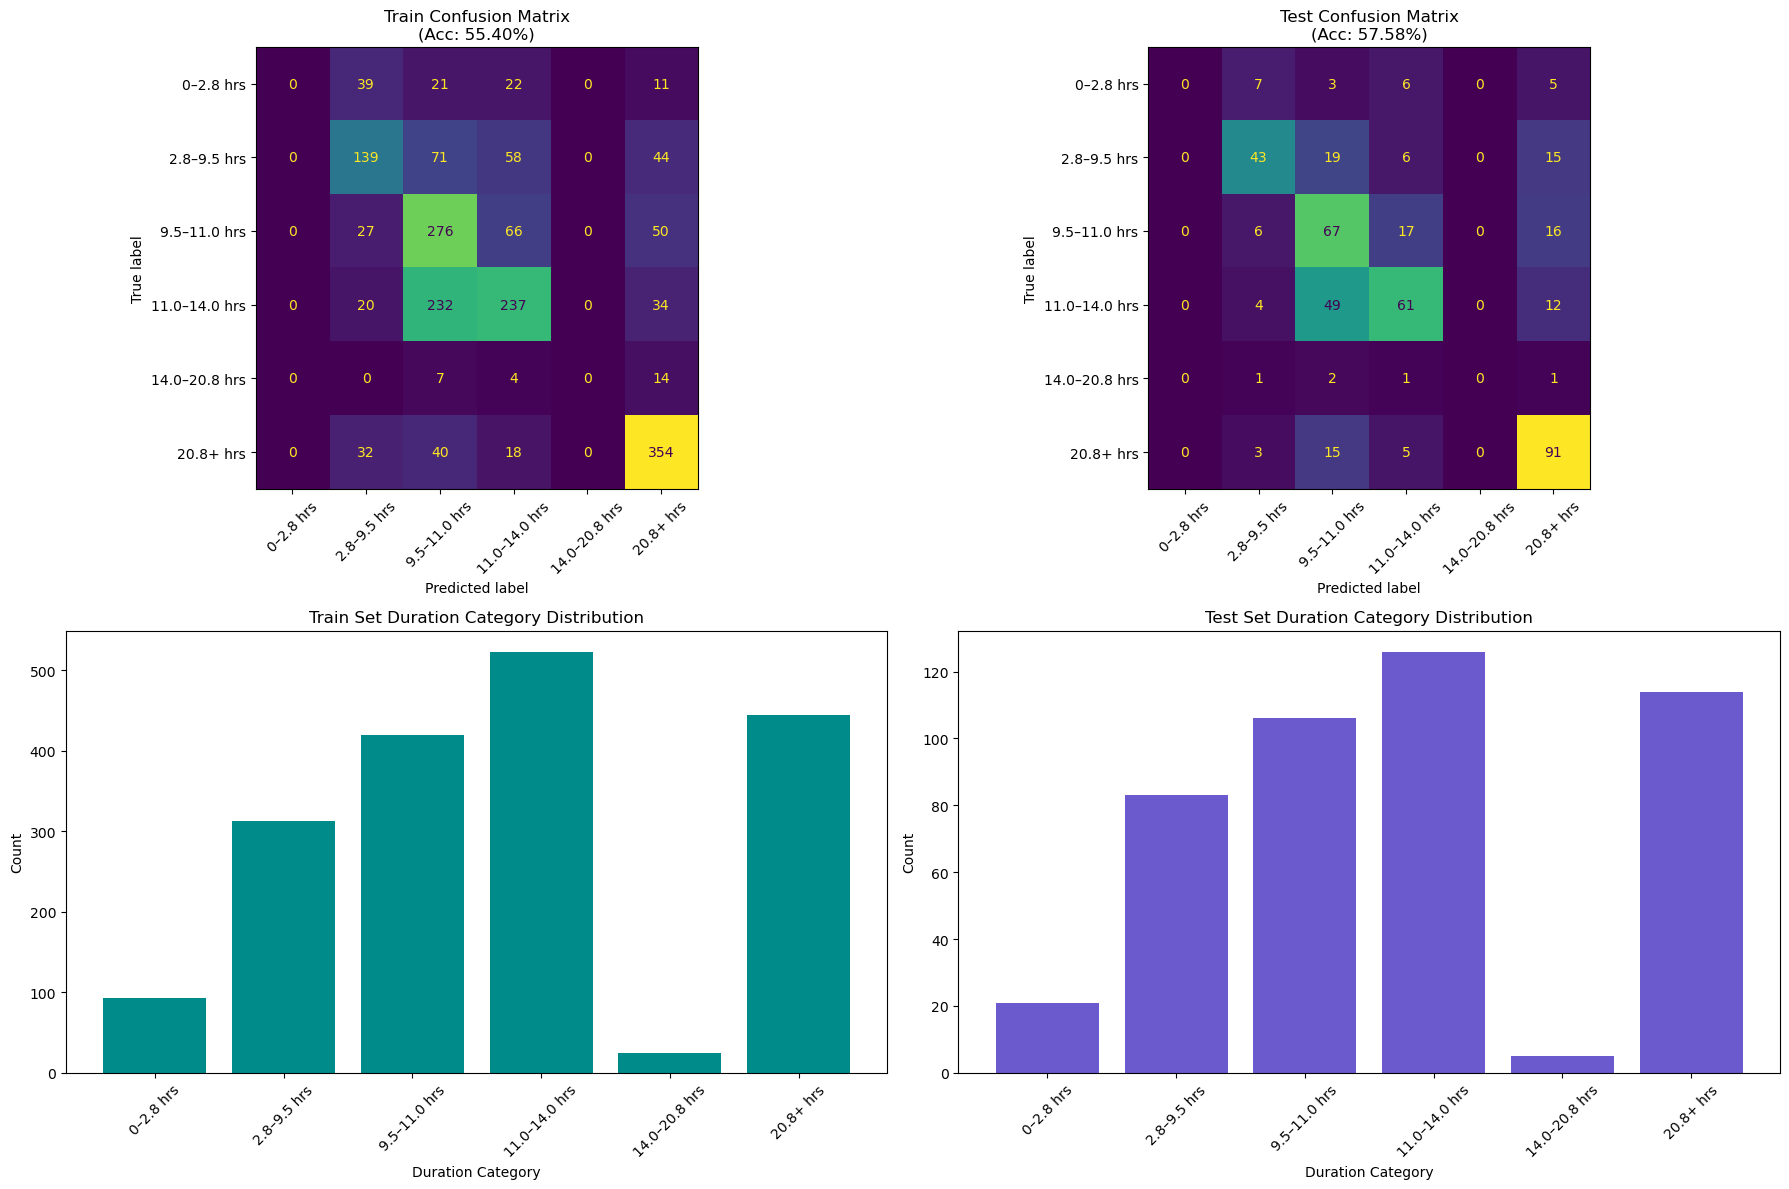

In [6]:
evaluate_lr_model(model, X_train, X_test, y_train, y_test)

### Model fitting on state-specific data

--- Region: SA ---
Using provided parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.00      0.00      0.00         3
  2.8–9.5 hrs       0.62      0.62      0.62         8
 9.5–11.0 hrs       0.00      0.00      0.00         1
11.0–14.0 hrs       0.75      0.75      0.75         4
14.0–20.8 hrs       0.00      0.00      0.00         2
    20.8+ hrs       0.86      1.00      0.93        38

     accuracy                           0.82        56
    macro avg       0.37      0.40      0.38        56
 weighted avg       0.73      0.82      0.77        56



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


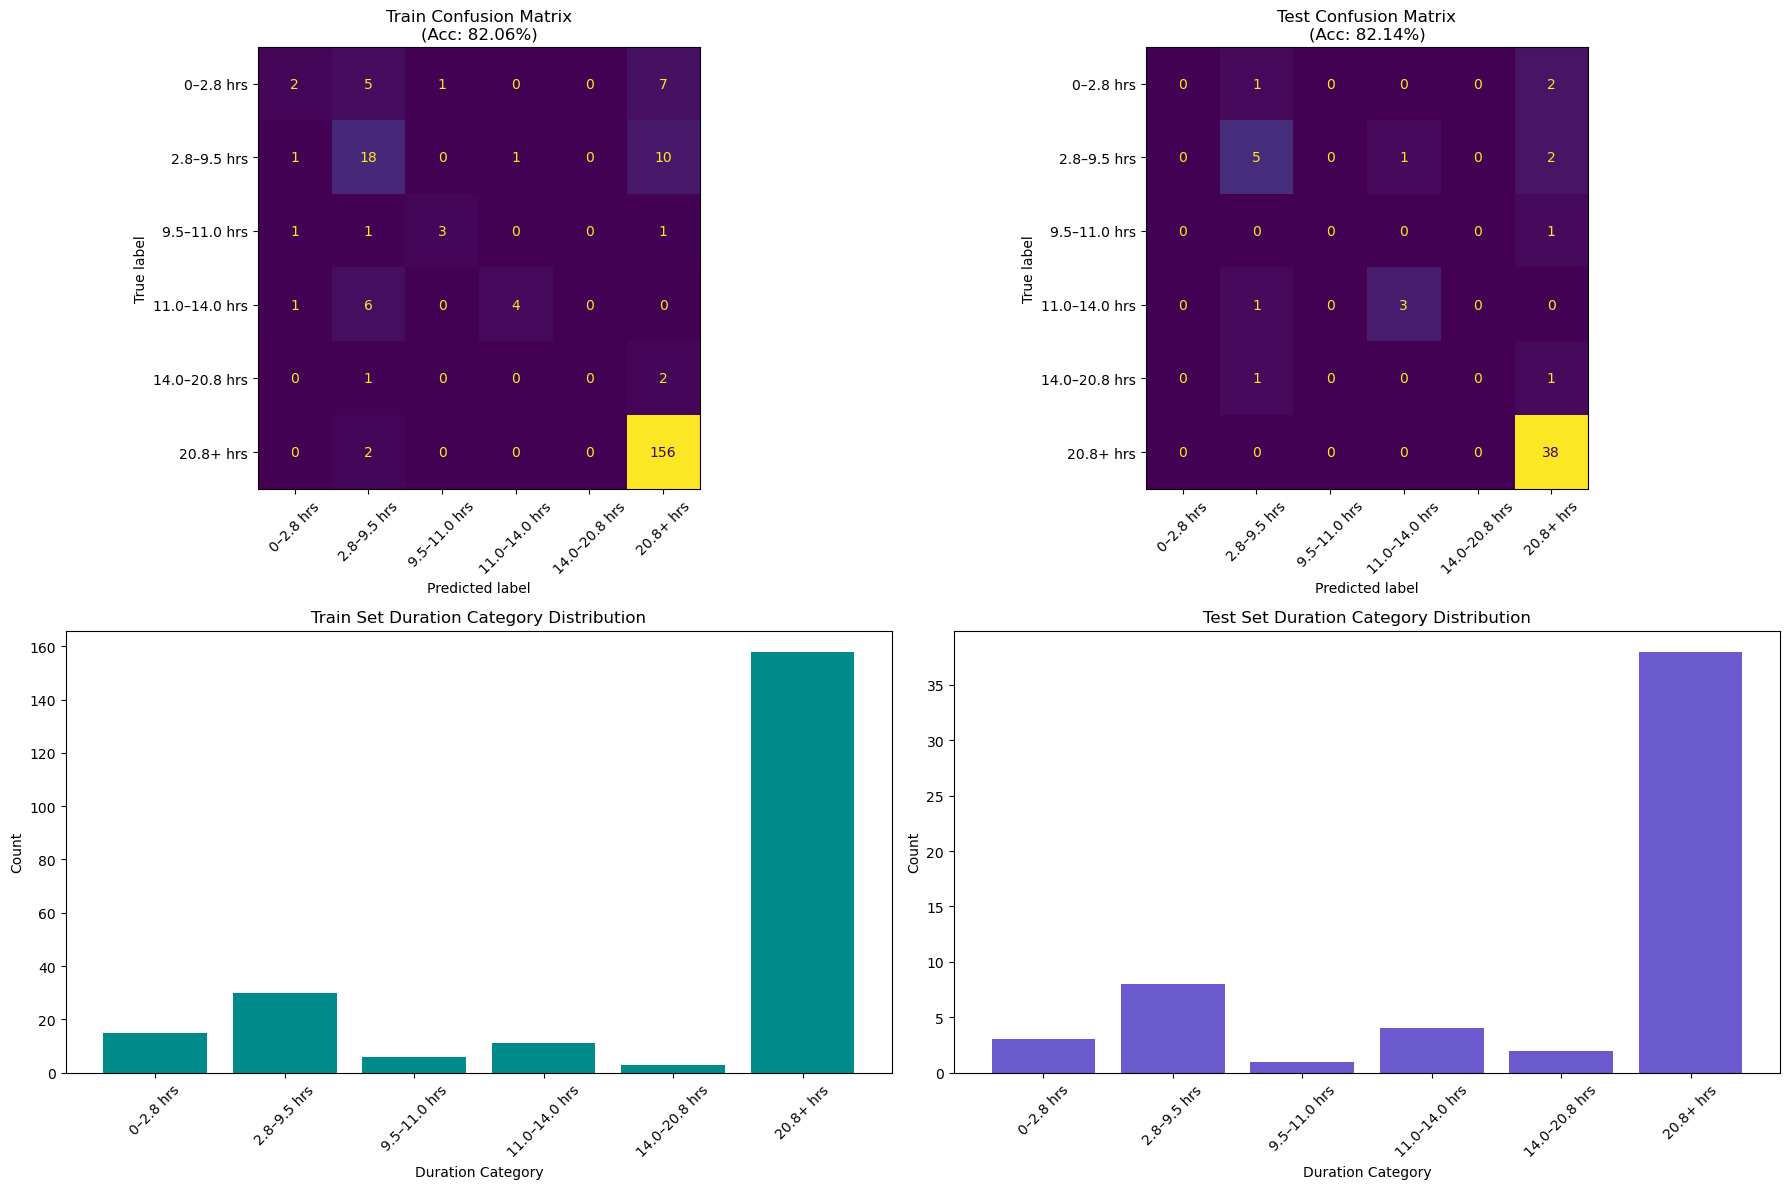

--- Region: VIC ---
Using provided parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.00      0.00      0.00         6
  2.8–9.5 hrs       0.00      0.00      0.00        19
 9.5–11.0 hrs       0.44      0.82      0.58        79
11.0–14.0 hrs       0.69      0.51      0.59       119
14.0–20.8 hrs       0.00      0.00      0.00         3
    20.8+ hrs       0.70      0.35      0.47        20

     accuracy                           0.54       246
    macro avg       0.30      0.28      0.27       246
 weighted avg       0.53      0.54      0.51       246



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


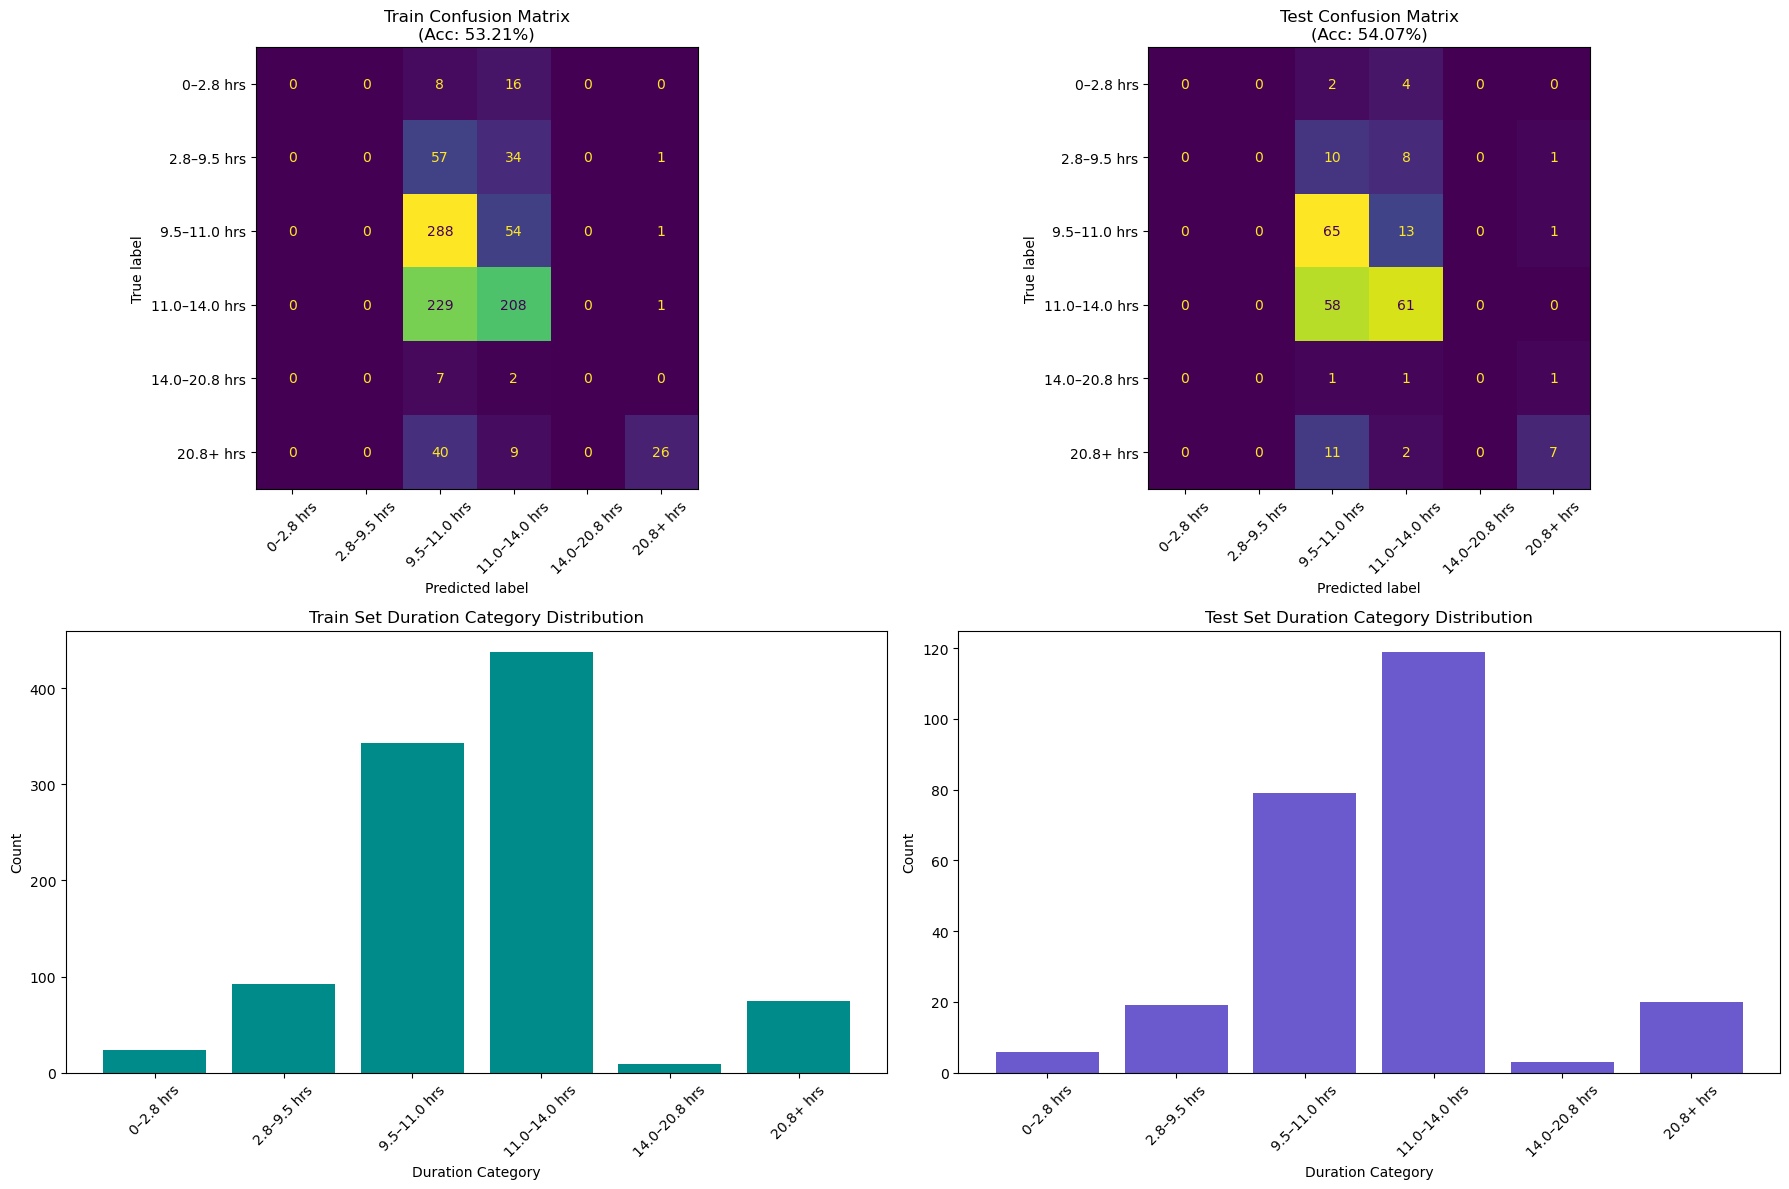

--- Region: TAS ---
Using provided parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.50      0.17      0.25         6
  2.8–9.5 hrs       0.63      0.86      0.73        14
 9.5–11.0 hrs       0.00      0.00      0.00         0
11.0–14.0 hrs       0.00      0.00      0.00         0
14.0–20.8 hrs       0.00      0.00      0.00         0
    20.8+ hrs       0.75      0.43      0.55         7

     accuracy                           0.59        27
    macro avg       0.31      0.24      0.25        27
 weighted avg       0.63      0.59      0.57        27



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/me

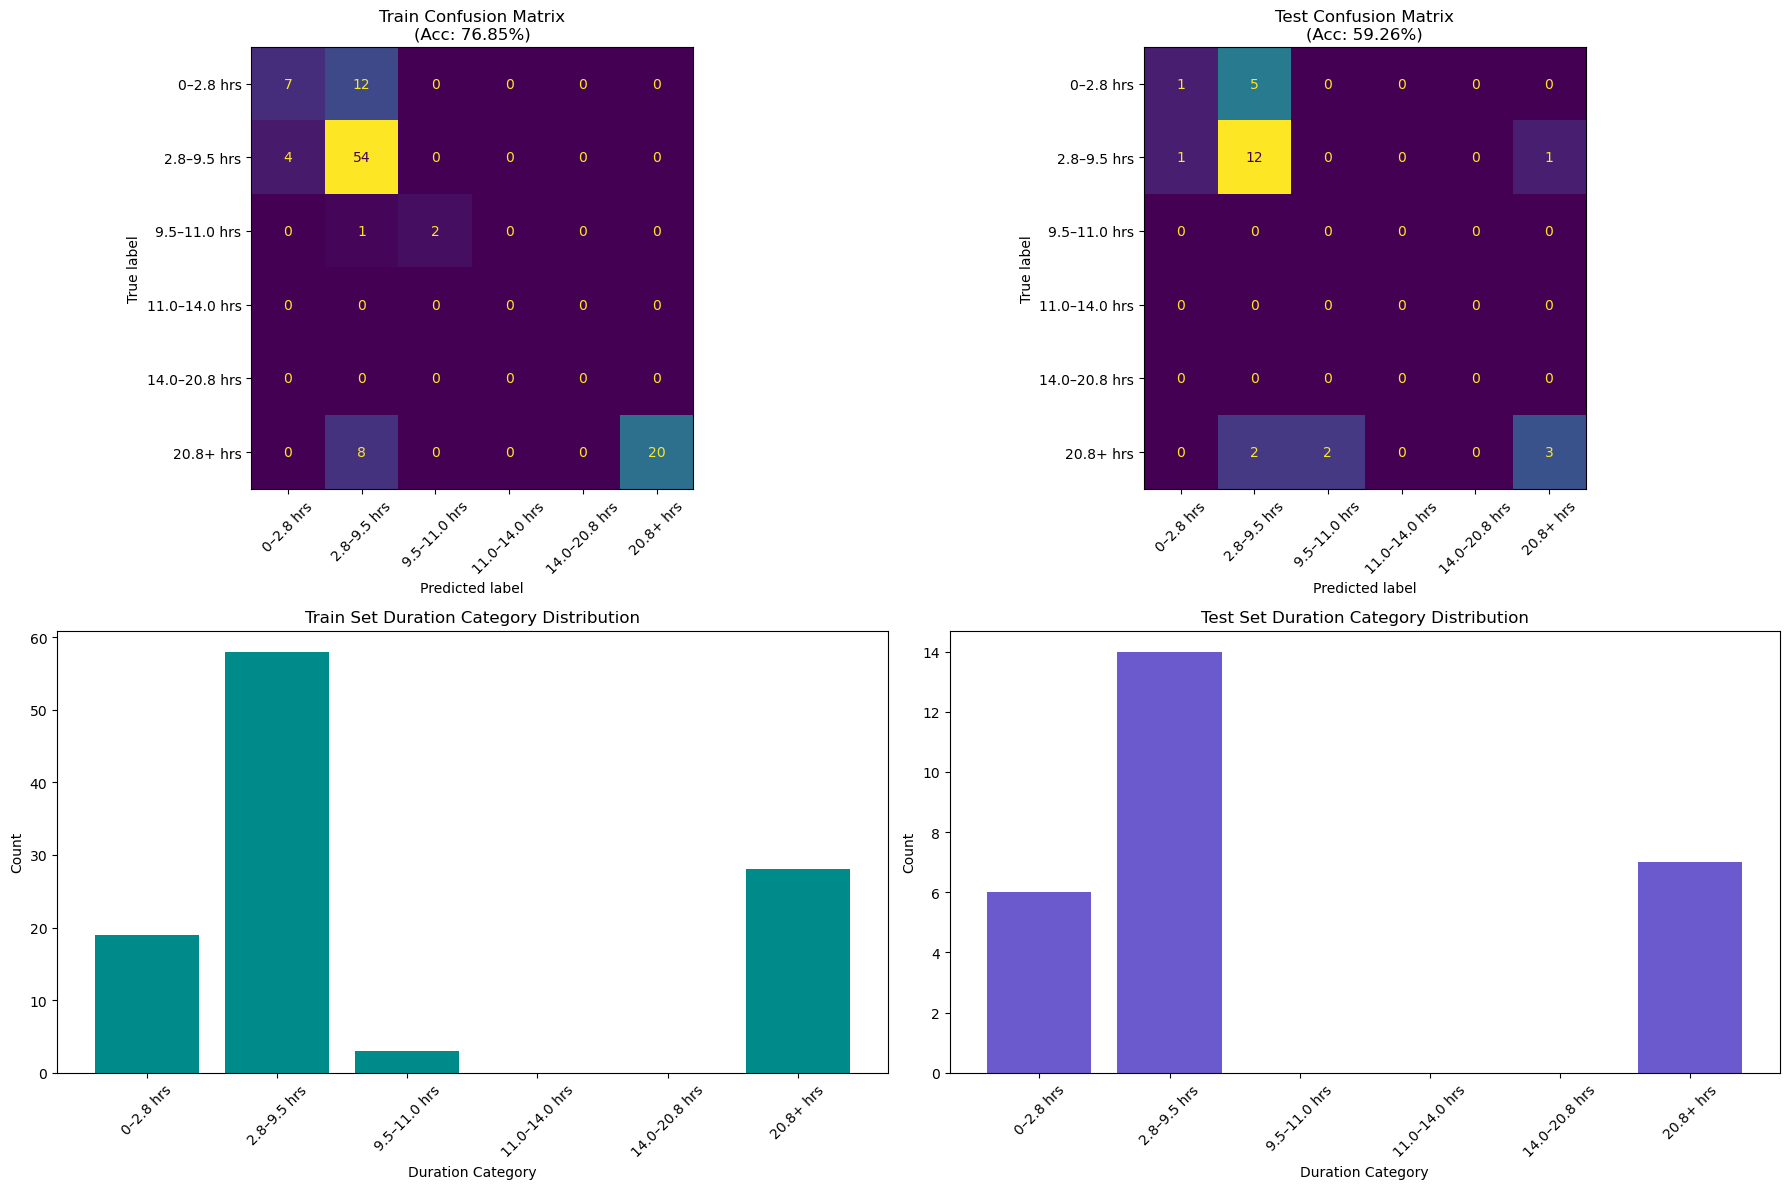

--- Region: QLD ---
Using provided parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.40      0.33      0.36         6
  2.8–9.5 hrs       0.92      0.71      0.80        34
 9.5–11.0 hrs       0.00      0.00      0.00         1
11.0–14.0 hrs       0.00      0.00      0.00         3
14.0–20.8 hrs       0.00      0.00      0.00         0
    20.8+ hrs       0.67      0.97      0.79        29

     accuracy                           0.74        73
    macro avg       0.33      0.33      0.33        73
 weighted avg       0.73      0.74      0.72        73



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/me

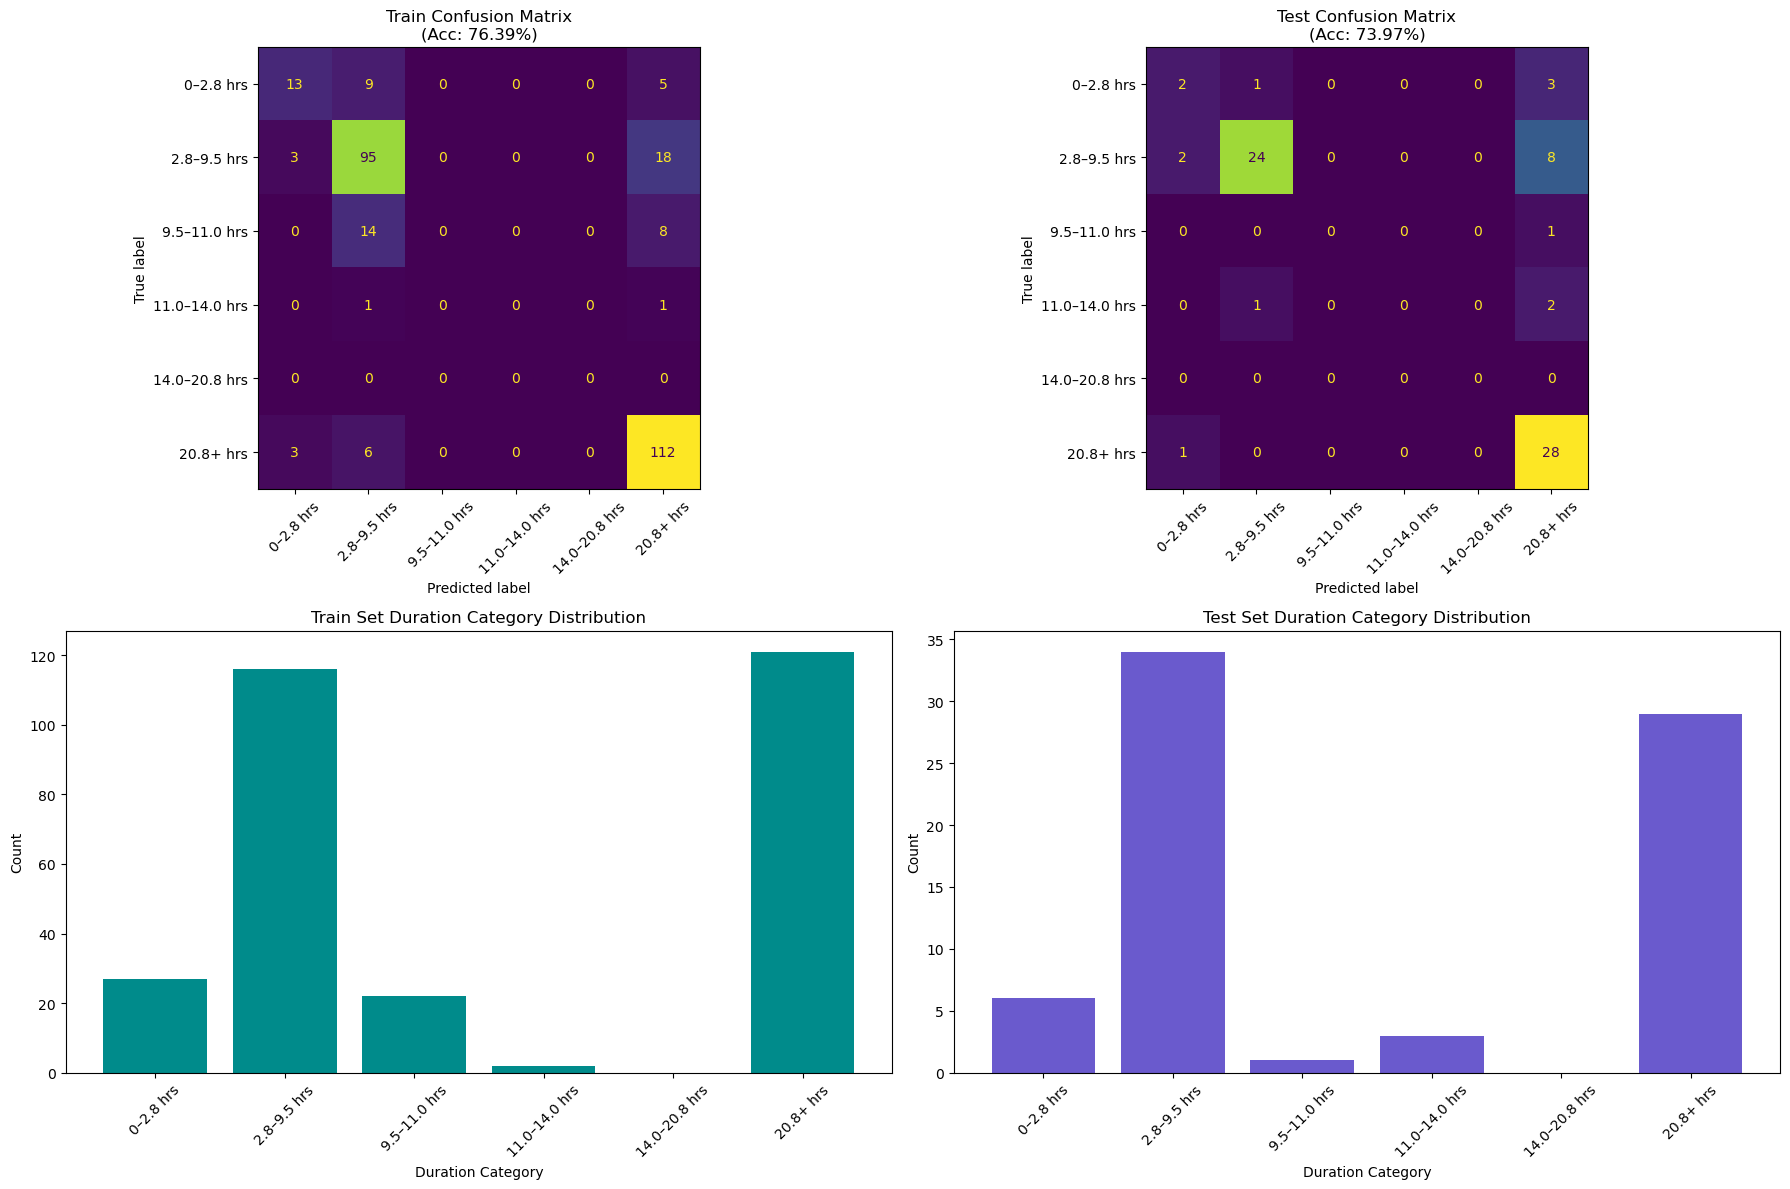

--- Region: NSW ---
Using provided parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.50      0.50      0.50         2
  2.8–9.5 hrs       0.50      0.20      0.29         5
 9.5–11.0 hrs       0.56      0.59      0.57        17
11.0–14.0 hrs       0.35      0.46      0.40        13
14.0–20.8 hrs       0.00      0.00      0.00         2
    20.8+ hrs       0.86      0.80      0.83        15

     accuracy                           0.56        54
    macro avg       0.46      0.42      0.43        54
 weighted avg       0.56      0.56      0.55        54



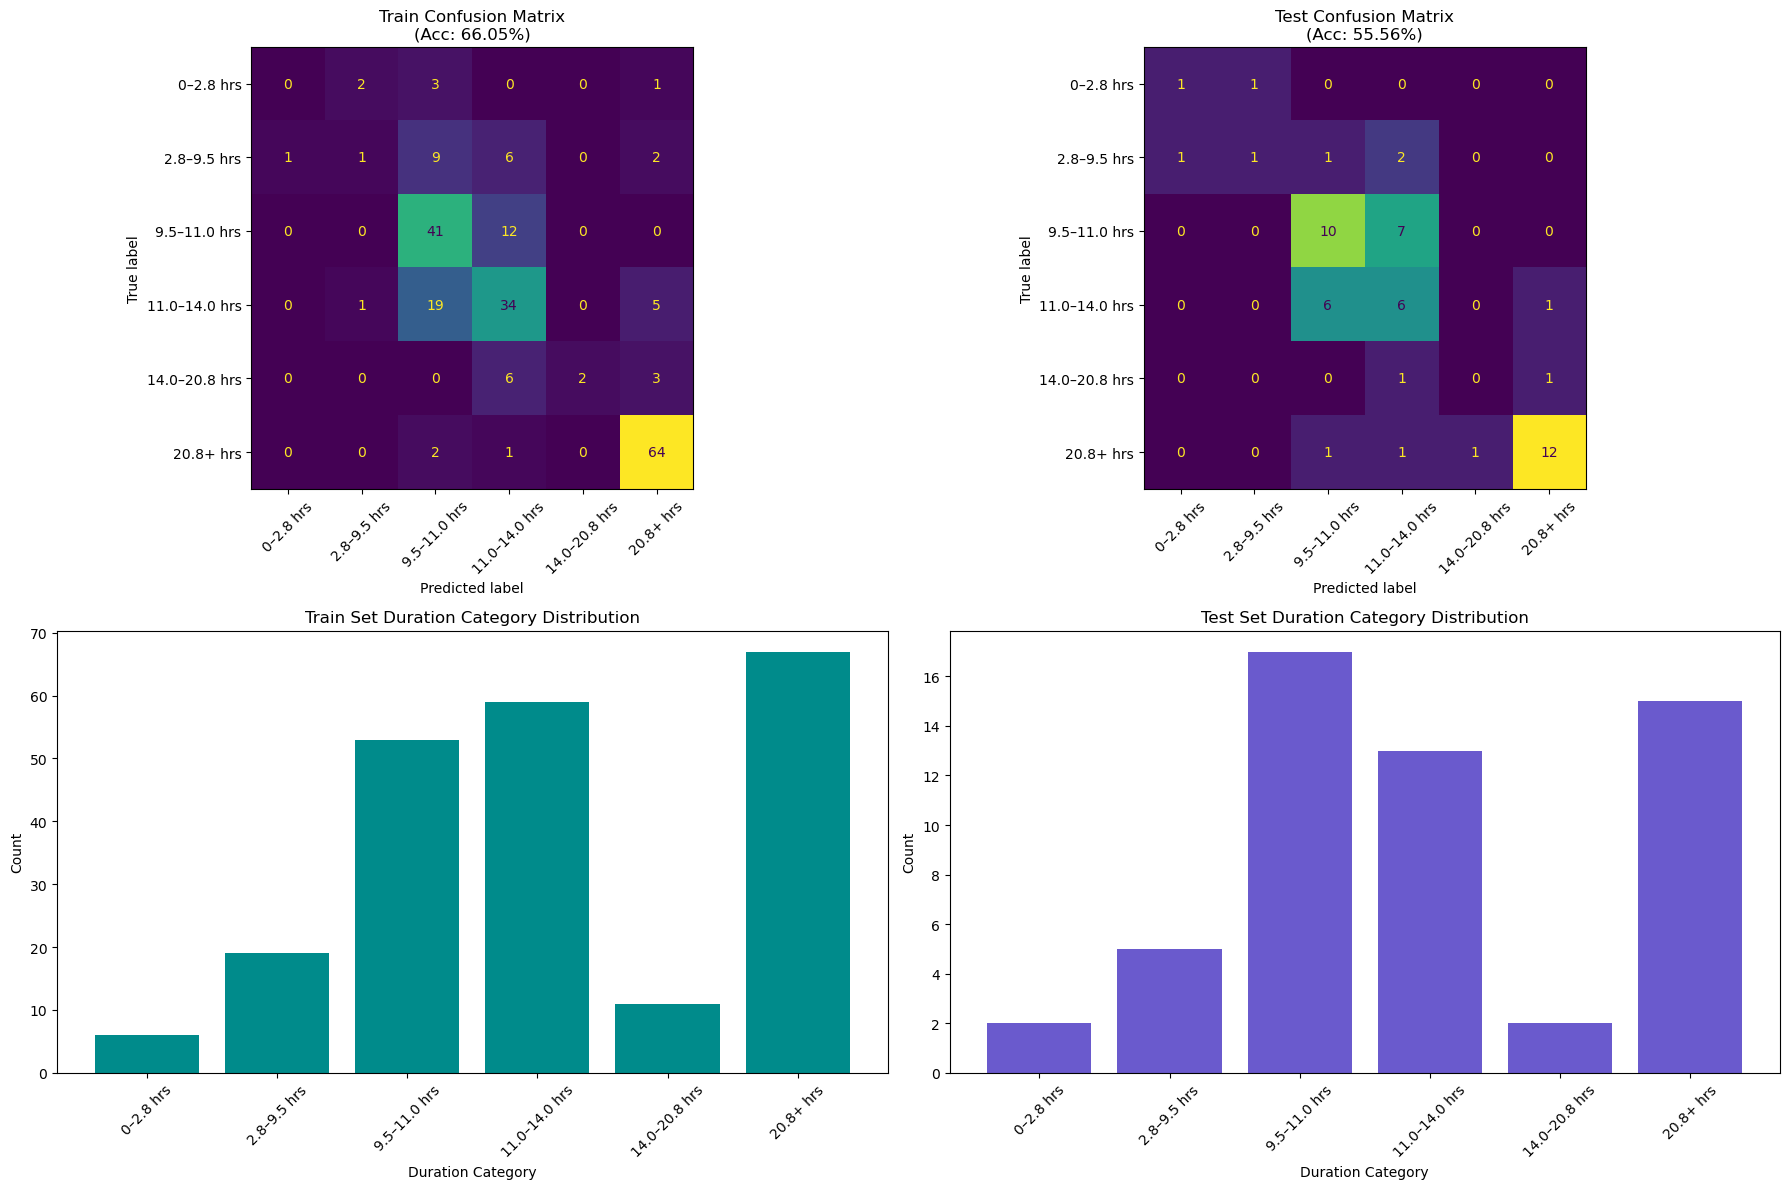

In [7]:
# Now, use the best hyperparameters to train models for each region
best_params = {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

# Dictionary to store models for each region
region_models = {}

# Loop through each unique region in the DataFrame
for region in df['Region'].unique():
    region_df = df[df['Region'] == region].copy()
    
    print(f"--- Region: {region} ---")
    
    # Train the model for the region
    model, X_train, X_test, y_train, y_test = train_lr_model(region_df, fine_tune=False, params=best_params)
    
    # Store the trained model for the region
    region_models[region] = model
    
    # Evaluate the model for the region
    evaluate_lr_model(model, X_train, X_test, y_train, y_test)
